In [1]:
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
plt.rcParams['legend.markerscale'] = 1.5
plt.rcParams['legend.handletextpad'] = 0.5
plt.rcParams['legend.labelspacing'] = 0.4
plt.rcParams['legend.borderpad'] = 0.5
plt.rcParams['font.size'] = 12
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['figure.figsize'] = (10, 6)

plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=22)

# 1. FWER

#### FWER — групповая вероятность ошибки первого рода

$$FWER = \mathbb{P}(FP > 0)$$

где $FP$ — число ложно положительных результатов.



Посмотрим, как меняется FWER при увеличении количества экспериментов.

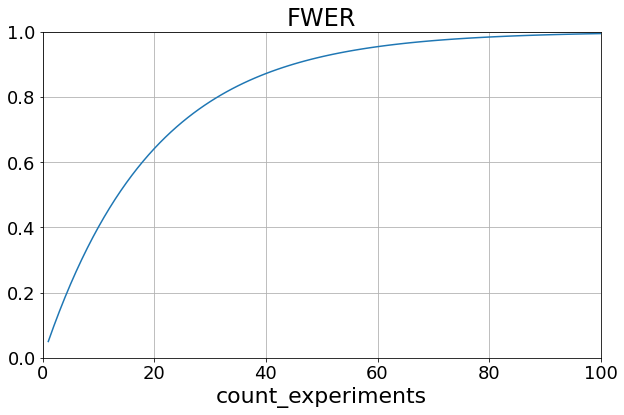

In [3]:
alpha = 0.05
count_experiments = np.arange(1, 101)
array_fwer = 1 - (1 - alpha) ** count_experiments

plt.plot(count_experiments, array_fwer, '-')
plt.grid()
plt.ylim([0, 1])
plt.xlim([0, 100])
plt.xlabel('count_experiments')
plt.title('FWER')
plt.show()

При увеличении количества экспериментов, вероятность допустить хоть одну ошибку I-го рода быстро увеличивается.

# 2. Метод Бонферрони

Пусть у нас есть N А/А-тестов. Сгенерируем N p-value из равномерного распределения на [0, 1], предполагая, что верна нулевая гипотеза о равенстве средних. Запомним, есть ли среди этих N тестов ошибки I-го рода. Повторим эту процедуру много раз, чтобы оценить FWER.

In [4]:
alpha = 0.05
size = 50

list_pvalues = [np.random.rand(size) for _ in range(10000)]

Применим метод без поправок к сгенерированным p-value

In [5]:
res = [int((pvalues <= alpha).sum() > 0) for pvalues in list_pvalues]
print(f'FWER без поправок: {np.mean(res):0.3f}')

FWER без поправок: 0.928


Применим метод Бонферрони к сгенерированным p-value.

In [6]:
def method_bonferroni(pvalues, alpha=0.05):
    """Применяет метод Бонферрони для проверки значимости изменений.
  
    pvalues - List[float] - список pvalue.
    alpha - float, уровень значимости.
    return - np.array, массив из нулей и единиц, 0 - эффекта нет, 1 - эффект есть.
    """
    m = len(pvalues)
    alpha_ = alpha / m
    res = (np.array(pvalues) <= alpha_).astype(int)
    return res


res_bonferroni = [int(np.sum(method_bonferroni(pvalues)) > 0) for pvalues in list_pvalues]
print(f'FWER с поправкой Бонферрони: {np.mean(res_bonferroni):0.3f}')

FWER с поправкой Бонферрони: 0.050


Получили FWER не превышающее значение alpha.

# 3. Метод Холма

In [7]:
def method_holm(pvalues, alpha=0.05):
    """Применяет метод Холма для проверки значимости изменений.

    pvalues - List[float] - список pvalue.
    alpha - float, уровень значимости.
    return - np.array, массив из нулей и единиц, 0 - эффекта нет, 1 - эффект есть.
    """
    m = len(pvalues)
    array_alpha = np.arange(m, 0, -1)
    array_alpha = alpha / array_alpha
    sorted_pvalue_indexes = np.argsort(pvalues)
    res = np.zeros(m)
    for idx, pvalue_index in enumerate(sorted_pvalue_indexes):
        pvalue = pvalues[pvalue_index]
        alpha_ = array_alpha[idx]
        if pvalue < alpha_:
            res[pvalue_index] = 1
        else:
            break
    res = res.astype(int)
    return res

In [8]:
res_holm = [int(np.sum(method_holm(pvalues)) > 0) for pvalues in list_pvalues]
print(f'FWER с поправкой Холма: {np.mean(res_holm):0.3f}')

FWER с поправкой Холма: 0.050


Когда все эксперименты без эффекта, ошибки первого рода практически совпадают на этих данных.

# 4. Сравнение методов

Будем увеличивать количество экспериментов с эффектом и считать долю «прокрасившихся» экспериментов среди экспериментов без эффекта (ошибка I рода) и доля «непрокрасившихся» среди экспериментов с эффектом (ошибка II рода).


Затем посмотрим как меняются:

- FWER;
- $\mathbb{P}(FN > 0)$ $-$ аналог FWER для ошибок II рода, вероятность хотя бы одного эксперимента с FN.

In [9]:
def method_baseline(pvalues, alpha=0.05):
    """Проверет значимость без поправок.
    
    pvalues - List[float] - список pvalue.
    alpha - float, уровень значимости.
    return - np.array, массив из нулей и единиц, 0 - эффекта нет, 1 - эффект есть.
    """
    res = (np.array(pvalues) <= alpha).astype(int)
    return res


dict_methods = {
    'baseline': method_baseline,
    'bonferroni': method_bonferroni,
    'holm': method_holm,
}

In [10]:
count_pilots = 100
group_size = 50
effect_size = 1
mean_ = 10
std_ = 1
n_iter = 500


list_count_pilot_with_effect = [1] + list(range(10, count_pilots, 10)) + [count_pilots - 1]
dict_method_error = {
    method_name: {
        count_pilot_with_effect: {
            'part_first_type_error': [], 'part_second_type_error': []
        }
        for count_pilot_with_effect in list_count_pilot_with_effect
    }
    for method_name in dict_methods
}


for count_pilot_with_effect in tqdm(list_count_pilot_with_effect):
    count_pilot_without_effect = count_pilots - count_pilot_with_effect

    for _ in range(n_iter):
        # без эффекта
        list_data = [
            (
                np.random.normal(mean_, std_, group_size),
                np.random.normal(mean_, std_, group_size)
            )
            for _ in range(count_pilot_without_effect)
        ]
        # с эффектом
        list_data += [
            (
                np.random.normal(mean_, std_, group_size),
                np.random.normal(mean_ + effect_size, std_, group_size)
            )
            for _ in range(count_pilot_with_effect)
        ]
        pvalues = [
            stats.ttest_ind(data_pilot, data_control)[1]
            for data_pilot, data_control in list_data
        ]
        for method_name, method in dict_methods.items():
            result_experiments = method(pvalues)
            dict_method_error[method_name][count_pilot_with_effect]['part_first_type_error'].append(
                np.mean(result_experiments[:count_pilot_without_effect])
            )
            dict_method_error[method_name][count_pilot_with_effect]['part_second_type_error'].append(
                1 - np.mean(result_experiments[count_pilot_without_effect:])
            )

  0%|          | 0/11 [00:00<?, ?it/s]

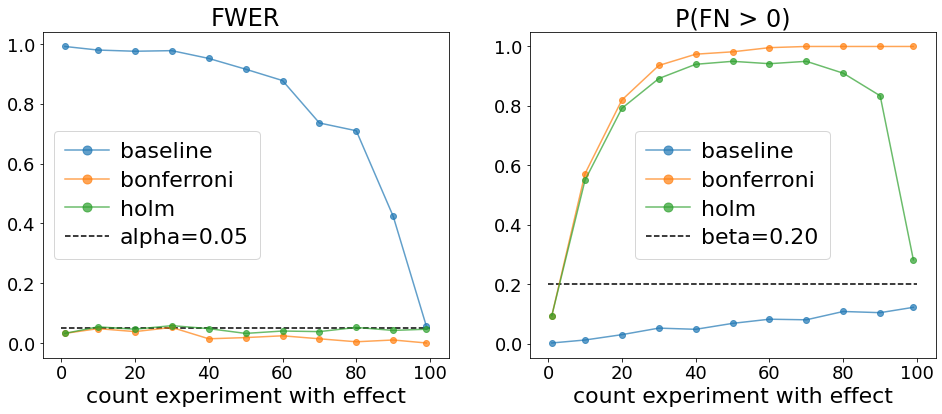

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].hlines(0.05, 0, count_pilots, 'k', linestyles='--', label='alpha=0.05')
axes[1].hlines(0.2, 0, count_pilots, 'k', linestyles='--', label='beta=0.20')

graph_types = ['FWER', 'P(FN > 0)']
for method_name, dict_errors in dict_method_error.items():
    X = []
    dict_Y = {graph_type: [] for graph_type in graph_types}
    for count_pilot, dict_ in dict_errors.items():
        X.append(count_pilot)
        dict_Y['FWER'].append(np.mean(np.array(dict_['part_first_type_error']) > 0))
        dict_Y['P(FN > 0)'].append(np.mean(np.array(dict_['part_second_type_error']) > 0))
    for graph_type, Y in dict_Y.items():
        idx = graph_types.index(graph_type)
        axes[idx].plot(X, Y, '-o', label=method_name, alpha=0.7)

for graph_type, ax in zip(graph_types, axes):
    ax.set_title(graph_type)
    ax.set_xlabel('count experiment with effect')
    if graph_type in graph_types:
        ax.legend()

FWER:

- baseline допускает ошибки I рода почти в 100% случаях, когда 99 экспериментов без эффекта, затем при уменьшении количества экспериментов вероятность ошибки уменьшается;
- bonferroni контролируют FWER на уровне 0.05, когда все эксперименты без эффекта, при увеличении количества экспериментов с эффектом FWER снижается;
- holm контролируют FWER на уровне 0.05.


$\mathbb{P}(FN>0)$:

- baseline допускает меньше других ошибки II рода;
- bonferroni чаще других ошибочно отвергает эксперименты с эффектом;
- holm при небольшом количестве экспериментов с эффектом имеем вероятность ошибок II рода, похожую на bonferroni, но при увеличении количества экспериментов с эффектом показывает себя лучше (реже ошибается).

# 5. Данные пиццерии

Разберём подробнее инцедент с пересечением экспериментов.

В нашем эксперименте (Font color) проверялась гипотеза о влиянии цвета текста на среднюю выручку с клиента. Но, не дожидаясь его окончания, кто-то запустил эксперимент с разными цветами фона кнопки (Background color). Для некоторых людей, попавших одновременно в оба эксперимента, текст и фон кнопки оказались одного цвета.

Даты экспериментов:

- Font color — с 2022-05-16 по 2022-05-23
- Background color — с 2022-05-19 по 2022-05-26

In [12]:
import os
from datetime import datetime, timedelta

In [13]:
begin_font = datetime(2022, 5, 16)
begin_back = datetime(2022, 5, 19)

end_font = datetime(2022, 5, 23)
end_back = datetime(2022, 5, 26)

In [14]:
URL_BASE = 'https://raw.githubusercontent.com/ab-courses/simulator-ab-datasets/main/2022-05-27/'

def read_database(file_name):
    return pd.read_csv(os.path.join(URL_BASE, file_name))

df_sales = read_database('2022-05-27T12_df_sales.csv')
df_sales['date'] = pd.to_datetime(df_sales['date'])
df_users = read_database('experiment_users.csv')

df_sales - информация о покупках, одна строка - один заказ. Атрибуты:
- sale_id - идентификатор покупки;
- date - дата покупки;
- count_pizza - количество пицц в заказе;
- count_drink - количество напитков в заказе;
- price - стоимость заказа;
- user_id - идентификатор пользователя;

df_users - список пользователей, участвовавших в экспериментах Font color и Background color. Если в столбце с соответствующей группой стоит 1, значит пользователь попал в эту группу.

In [15]:
df_users.head()

,user_id,Font color (control),Font color (pilot),Background color (control),Background color (pilot)
0,ec6536,1,0,0,0
1,82fdba,1,0,1,0
2,83d7c5,1,0,0,0
3,294d1c,1,0,1,0
4,faaa6f,1,0,0,1


Сгруппируем по вариантам попадания в разные группы, посчитаем размеры этих групп.

In [16]:
df_users.groupby(df_users.columns.tolist()[1:])[['user_id']].count().reset_index()

,Font color (control),Font color (pilot),Background color (control),Background color (pilot),user_id
0,0,0,0,1,6294
1,0,0,1,0,6277
2,0,1,0,0,6553
3,0,1,0,1,6486
4,0,1,1,0,6658
5,1,0,0,0,6372
6,1,0,0,1,6643
7,1,0,1,0,6579


Построим графики суммарной выручки по дням по группам пользователям, в зависимости от того, в какие экспериментальные группы они попали.

In [17]:
delta = timedelta(15)
df_sales_filtered = (
    df_sales
    [(df_sales['date'] >= begin_font - delta) & (df_sales['date'] < end_back)]
    [['user_id', 'price', 'date']]
    .copy()
)

df = pd.merge(
    df_users,
    df_sales_filtered,
    on='user_id',
    how='inner'
)

df['day'] = df['date'].dt.date
df['group'] = 'control'
df.loc[(df['Font color (pilot)'] == 1) & (df['Background color (pilot)'] == 0), 'group'] = 'Font pilot'
df.loc[(df['Font color (pilot)'] == 0) & (df['Background color (pilot)'] == 1), 'group'] = 'Background pilot'
df.loc[(df['Font color (pilot)'] == 1) & (df['Background color (pilot)'] == 1), 'group'] = 'both pilot'

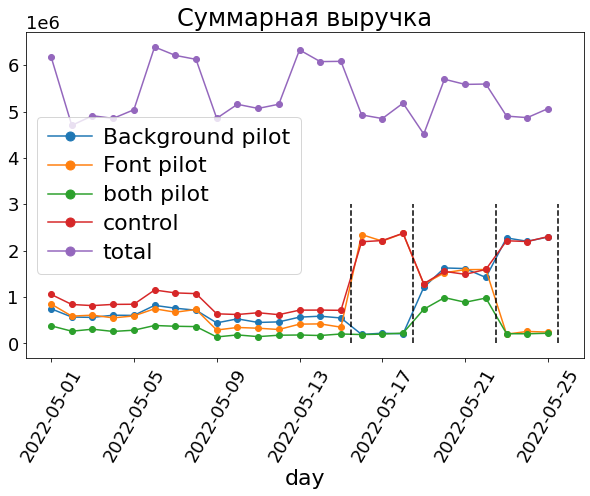

In [18]:
df_agg = df.groupby(['group', 'day'])[['price']].sum().reset_index().rename(columns={'price': 'revenue'})
df_pivot = df_agg.pivot(index='day', columns='group', values='revenue')

df_pivot = pd.merge(
    df_pivot,
    df_sales_filtered.groupby(df_sales_filtered['date'].dt.date)[['price']].sum().rename(columns={'price': 'total'}),
    left_index=True,
    right_index=True,
    how='left'
)

df_pivot.plot(rot=60, style='-o')

for date_ in [begin_font, end_font, begin_back, end_back]:
    plt.plot([date_ - timedelta(0.5), date_ - timedelta(0.5)], [0, 3000000], '--k')
    
plt.title('Суммарная выручка')
plt.show()

Во время пересечения экспериментов в каждой из 4-х групп было примерно одинаковое количество человек. Видно, что выручка у группы, которая попала сразу в оба эксперимента, меньше.

## Оценка эксперимента

Оценим значимость отличий средней выручки с пользователей с помощью  t-test.

In [19]:
df_users_exp = (
    df_users
    [(df_users['Font color (control)'] == 1) | (df_users['Font color (pilot)'] == 1)]
    [['user_id', 'Font color (control)', 'Font color (pilot)']]
    .copy()
)

df_sales_exp = (
    df_sales
    [(df_sales['date'] >= begin_font) & (df_sales['date'] < end_font)]
    .groupby('user_id')[['price']].sum()
    .reset_index()
)

df_exp = pd.merge(df_users_exp, df_sales_exp, on='user_id', how='left').fillna(0)

In [20]:
control = df_exp[df_exp['Font color (control)'] == 1]['price'].values
pilot = df_exp[df_exp['Font color (pilot)'] == 1]['price'].values

print(f'len(control) = {len(control)}, len(pilot) = {len(pilot)}')
print(f'np.mean(pilot) - np.mean(control) = {np.mean(pilot) - np.mean(control):0.2f}')
print(stats.ttest_ind(control, pilot))

len(control) = 19594, len(pilot) = 19697
np.mean(pilot) - np.mean(control) = -111.11
Ttest_indResult(statistic=12.351179891447554, pvalue=5.575006488410081e-35)


Средняя выручка с пользователя значимо уменьшилась.

Попробуем убрать клиентов, попавших во второй эксперимент.

In [21]:
df_users_exp_two = (
    df_users
    [
        ((df_users['Font color (control)'] == 1) | (df_users['Font color (pilot)'] == 1))
        & (df_users['Background color (pilot)'] == 0)
    ]
    [['user_id', 'Font color (control)', 'Font color (pilot)']]
    .copy()
)

df_exp = pd.merge(df_users_exp_two, df_sales_exp, on='user_id', how='left').fillna(0)

In [22]:
control = df_exp[df_exp['Font color (control)'] == 1]['price'].values
pilot = df_exp[df_exp['Font color (pilot)'] == 1]['price'].values

print(f'len(control) = {len(control)}, len(pilot) = {len(pilot)}')
print(f'np.mean(pilot) - np.mean(control) = {np.mean(pilot) - np.mean(control):0.2f}')
print(stats.ttest_ind(control, pilot))

len(control) = 12951, len(pilot) = 13211
np.mean(pilot) - np.mean(control) = -4.22
Ttest_indResult(statistic=0.38385425255319694, pvalue=0.7010895944356124)


Отличия статистически незначимые